In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys,os
sys.path.append(os.path.realpath('..'))

from core.data import load_records

In [12]:
source = './records/macho/train'
batch = load_records(source, batch_size=100)

In [13]:
for x in batch:
    print(tf.reduce_sum(x[0]))

tf.Tensor(-56262.094, shape=(), dtype=float32)
tf.Tensor(-55419.227, shape=(), dtype=float32)
tf.Tensor(-57208.598, shape=(), dtype=float32)
tf.Tensor(-55466.113, shape=(), dtype=float32)
tf.Tensor(-53070.863, shape=(), dtype=float32)
tf.Tensor(-50441.836, shape=(), dtype=float32)
tf.Tensor(-51722.805, shape=(), dtype=float32)
tf.Tensor(-49160.297, shape=(), dtype=float32)
tf.Tensor(-40634.746, shape=(), dtype=float32)
tf.Tensor(-41420.973, shape=(), dtype=float32)
tf.Tensor(-15190.32, shape=(), dtype=float32)


In [14]:
def create_padding_mask(tensor, lengths):
    ''' Create mask given a tensor and true length '''
    lengths_transposed = tf.expand_dims(lengths, 1)
    rangex = tf.range(0, tf.shape(tensor)[1], 1)
    range_row = tf.expand_dims(rangex, 0)
    # Use the logical operations to create a mask
    mask = tf.greater(range_row, lengths_transposed)
    return tf.cast(mask, tf.float32)

def create_prediction_mask(tensor, frac=0.15):
    time_steps = tensor.shape[1] 
    indices = tf.map_fn(lambda x: tf.random.shuffle(tf.range(time_steps))[:int(time_steps*frac)], 
                        tf.range(tensor.shape[0]))
    one_hot = tf.one_hot(indices, time_steps)
    mask    = tf.reduce_sum(one_hot, 1)
    return tf.cast(mask, tf.float32)

def create_mask(tensor, length=None):
    mask = create_prediction_mask(tensor)
    if length is not None:
        mask_1 = create_padding_mask(tensor, length)
        mask = tf.maximum(mask, mask_1)
        
    return mask

In [6]:
plt.style.use('dark_background')

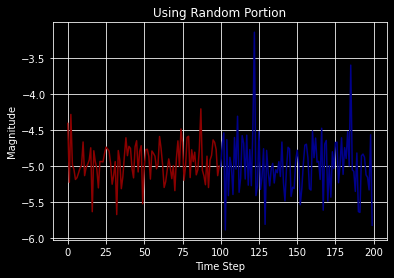

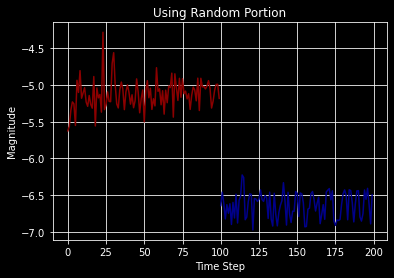

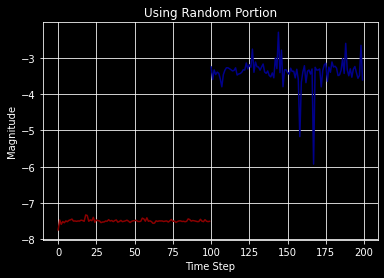

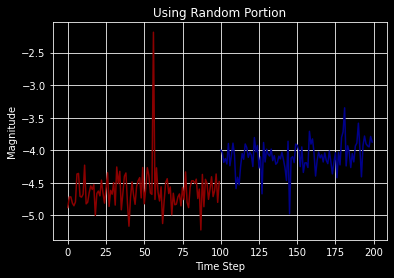

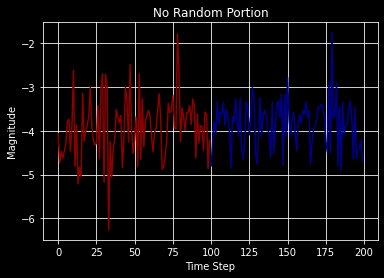

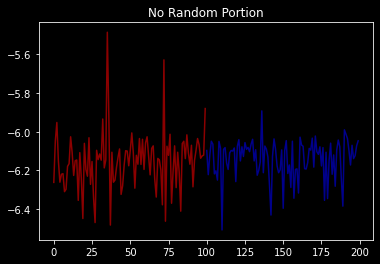

In [7]:
for i, (x1, x2, length, cls) in enumerate(batch):
    mask1 = create_mask(x1)
    mask2 = create_mask(x2)
    cls = tf.tile(cls, [1, 1])
    sep = tf.tile([[102.]], [x1.shape[0],1])
    mask = tf.concat([cls, mask1, sep, mask2], 1)
    dim_mask = tf.shape(mask)[1]
    mask = tf.tile(mask, [1, dim_mask])
    mask = tf.reshape(mask, [tf.shape(mask)[0], dim_mask, dim_mask])
    mask = tf.expand_dims(mask, 1)

    cls = tf.tile(tf.expand_dims(cls, 2), [1, 1, x1.shape[-1]])
    sep = tf.tile([[[102.]]], [x1.shape[0],1,x1.shape[-1]])
    inputs = tf.concat([cls, x1, sep, x2], 1)
    
    
    plt.figure()
   

    plt.plot(range(100), inputs[0][1:101, 1], color='darkred', label=cls)
    plt.plot(range(100, 200), inputs[0][102:, 1], color='darkblue', label=cls) 

    if cls.numpy()[0][0][0] == 0:
        plt.title('No Random Portion')
    else:
        plt.title('Using Random Portion')

    
    if i == 5:break
    plt.xlabel('Time Step')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()
